# Search Log Viewer
Parse and visualize the logs from the search base class

In [127]:
import os
import sys
from pathlib import Path
import json
import math
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Default plot size
plt.rcParams["figure.figsize"] = [30,15]

In [157]:
def add_thumbnail(ax, file, x, y):
    image = plt.imread(str(file))
    # Check if the RED (0 index) channel is white (1.0)
    bg_mask = image[:,:,0] == 1.0
    # Then set the ALPHA channel to 0
    image[bg_mask, 3] = 0
    offset_image = OffsetImage(image, zoom=0.4)
    ab = AnnotationBbox(offset_image, (x, y), frameon=False)
    ax.add_artist(ab)

def plot_log(log_file):
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    current_iou = 0
    prev_iou = 0
    valid_step = []
    valid_iou = []
    invalid_step = []
    invalid_iou = []
    all_step = []
    max_iou = []
    rollout_lines = []
    prev_rollout_attempt = 0
    thumbnails = []
    for action in log_data:
        rollout_attempt = action["rollout_attempt"]
        if rollout_attempt != prev_rollout_attempt:
            current_iou = 0
        step = action["used_budget"]
        iou = action["current_iou"]
        all_step.append(step)
        max_iou.append(action["max_iou"])
        if iou is None:
            invalid_step.append(step)
            invalid_iou.append(current_iou)
        else:
            valid_step.append(step)
            valid_iou.append(iou)
            current_iou = iou
        if rollout_attempt != prev_rollout_attempt:
            prev_rollout_attempt = rollout_attempt
            rollout_lines.append(step)
        iou_delta = math.fabs(prev_iou - current_iou)
        if "screenshot" in action and iou is not None and iou_delta > 0.15:
            thumbnails.append({
                "x": step - 0.5,
                "y": current_iou,
                "file": log_file.parent / action["screenshot"]
            })
        prev_iou = current_iou
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim([-0.05, 1.05])
    # Rollout lines
    for line in rollout_lines:
        plt.axvline(x=line, color='silver')
    for thumbnail in thumbnails:
        add_thumbnail(ax, thumbnail["file"], thumbnail["x"], thumbnail["y"])
    ax.scatter(invalid_step, invalid_iou, 75, color='r')
    ax.scatter(valid_step, valid_iou, 75, color='b')
    ax.plot(all_step, max_iou)
    ax.set_xlabel('Step')
    ax.set_ylabel('IoU')
    ax.set_title(f"{log_file.stem}")
    plt.show()

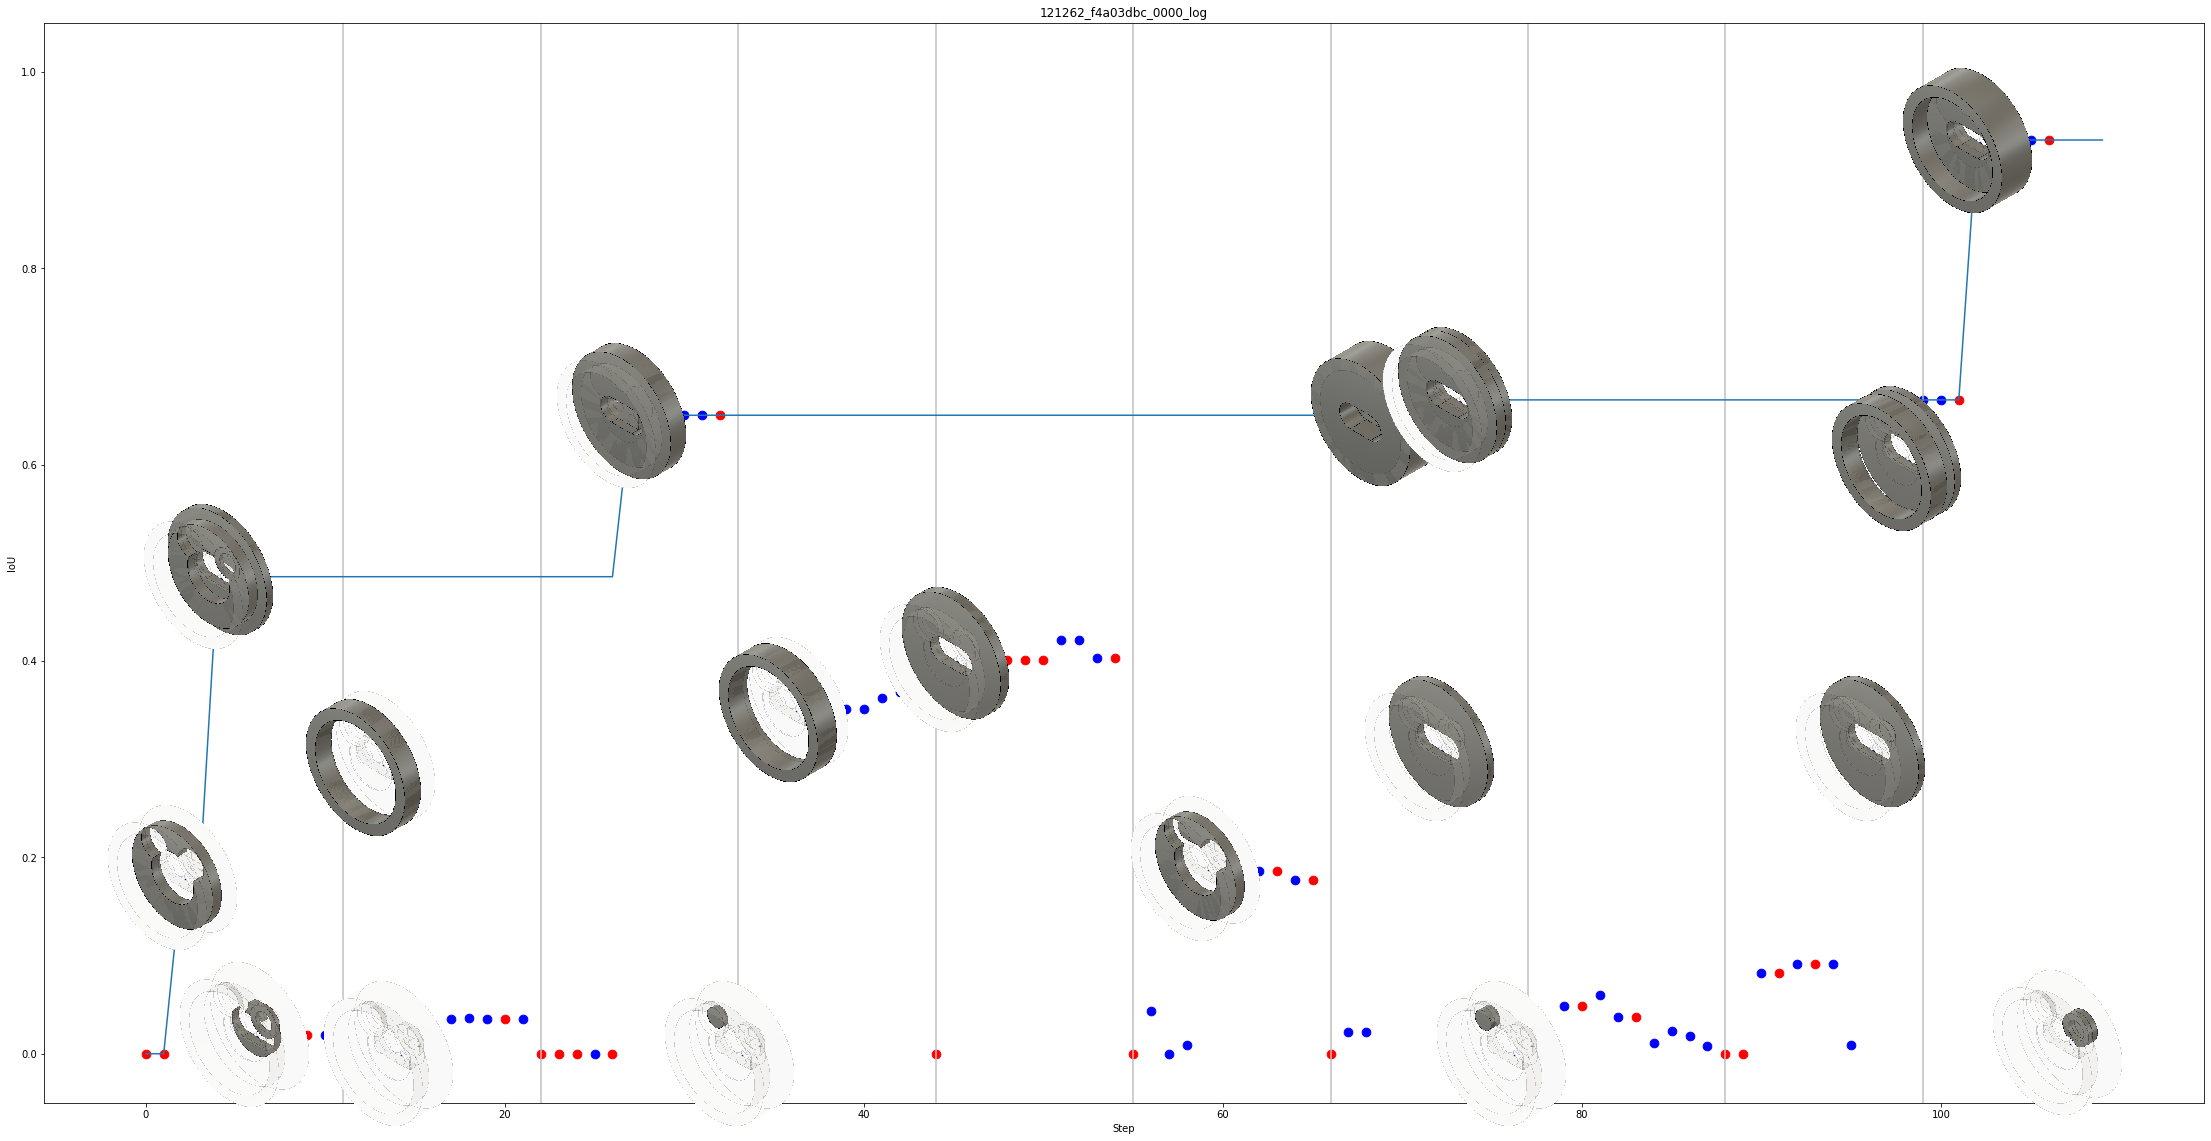

In [160]:
log_file = Path("121262_f4a03dbc_0000/121262_f4a03dbc_0000_log.json")
plot_log(log_file)